In [1]:
import os
import sys
import glob

sys.path.append("Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_left_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [3]:
measure_noise_csv_files = [
    "data/2024-09-26/2024-09-26-17:36/landmarks_all_2024-09-26-17:36.csv",
    "data/2024-09-26/2024-09-26-17:39/landmarks_all_2024-09-26-17:39.csv",
    "data/2024-09-26/2024-09-26-17:40/landmarks_all_2024-09-26-17:40.csv",
    "data/2024-09-26/2024-09-26-17:42/landmarks_all_2024-09-26-17:42.csv",
    "data/2024-09-26/2024-09-26-17:43/landmarks_all_2024-09-26-17:43.csv",
    "data/2024-09-26/2024-09-26-17:44/landmarks_all_2024-09-26-17:44.csv"
]

Get the noise when the left arm does not move

In [4]:
lmks_error = []

for csv_file in measure_noise_csv_files:
    data = pd.read_csv(csv_file)
    total_rows = len(data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values

    for i in range(1, gt_data.shape[0]):
        lmks_error.append(np.abs(gt_data[i] - gt_data[0]))

lmks_error = np.array(lmks_error)
lmks_error = lmks_error.reshape(-1, 3, 48)
lmks_error = np.transpose(lmks_error, (0, 2, 1))

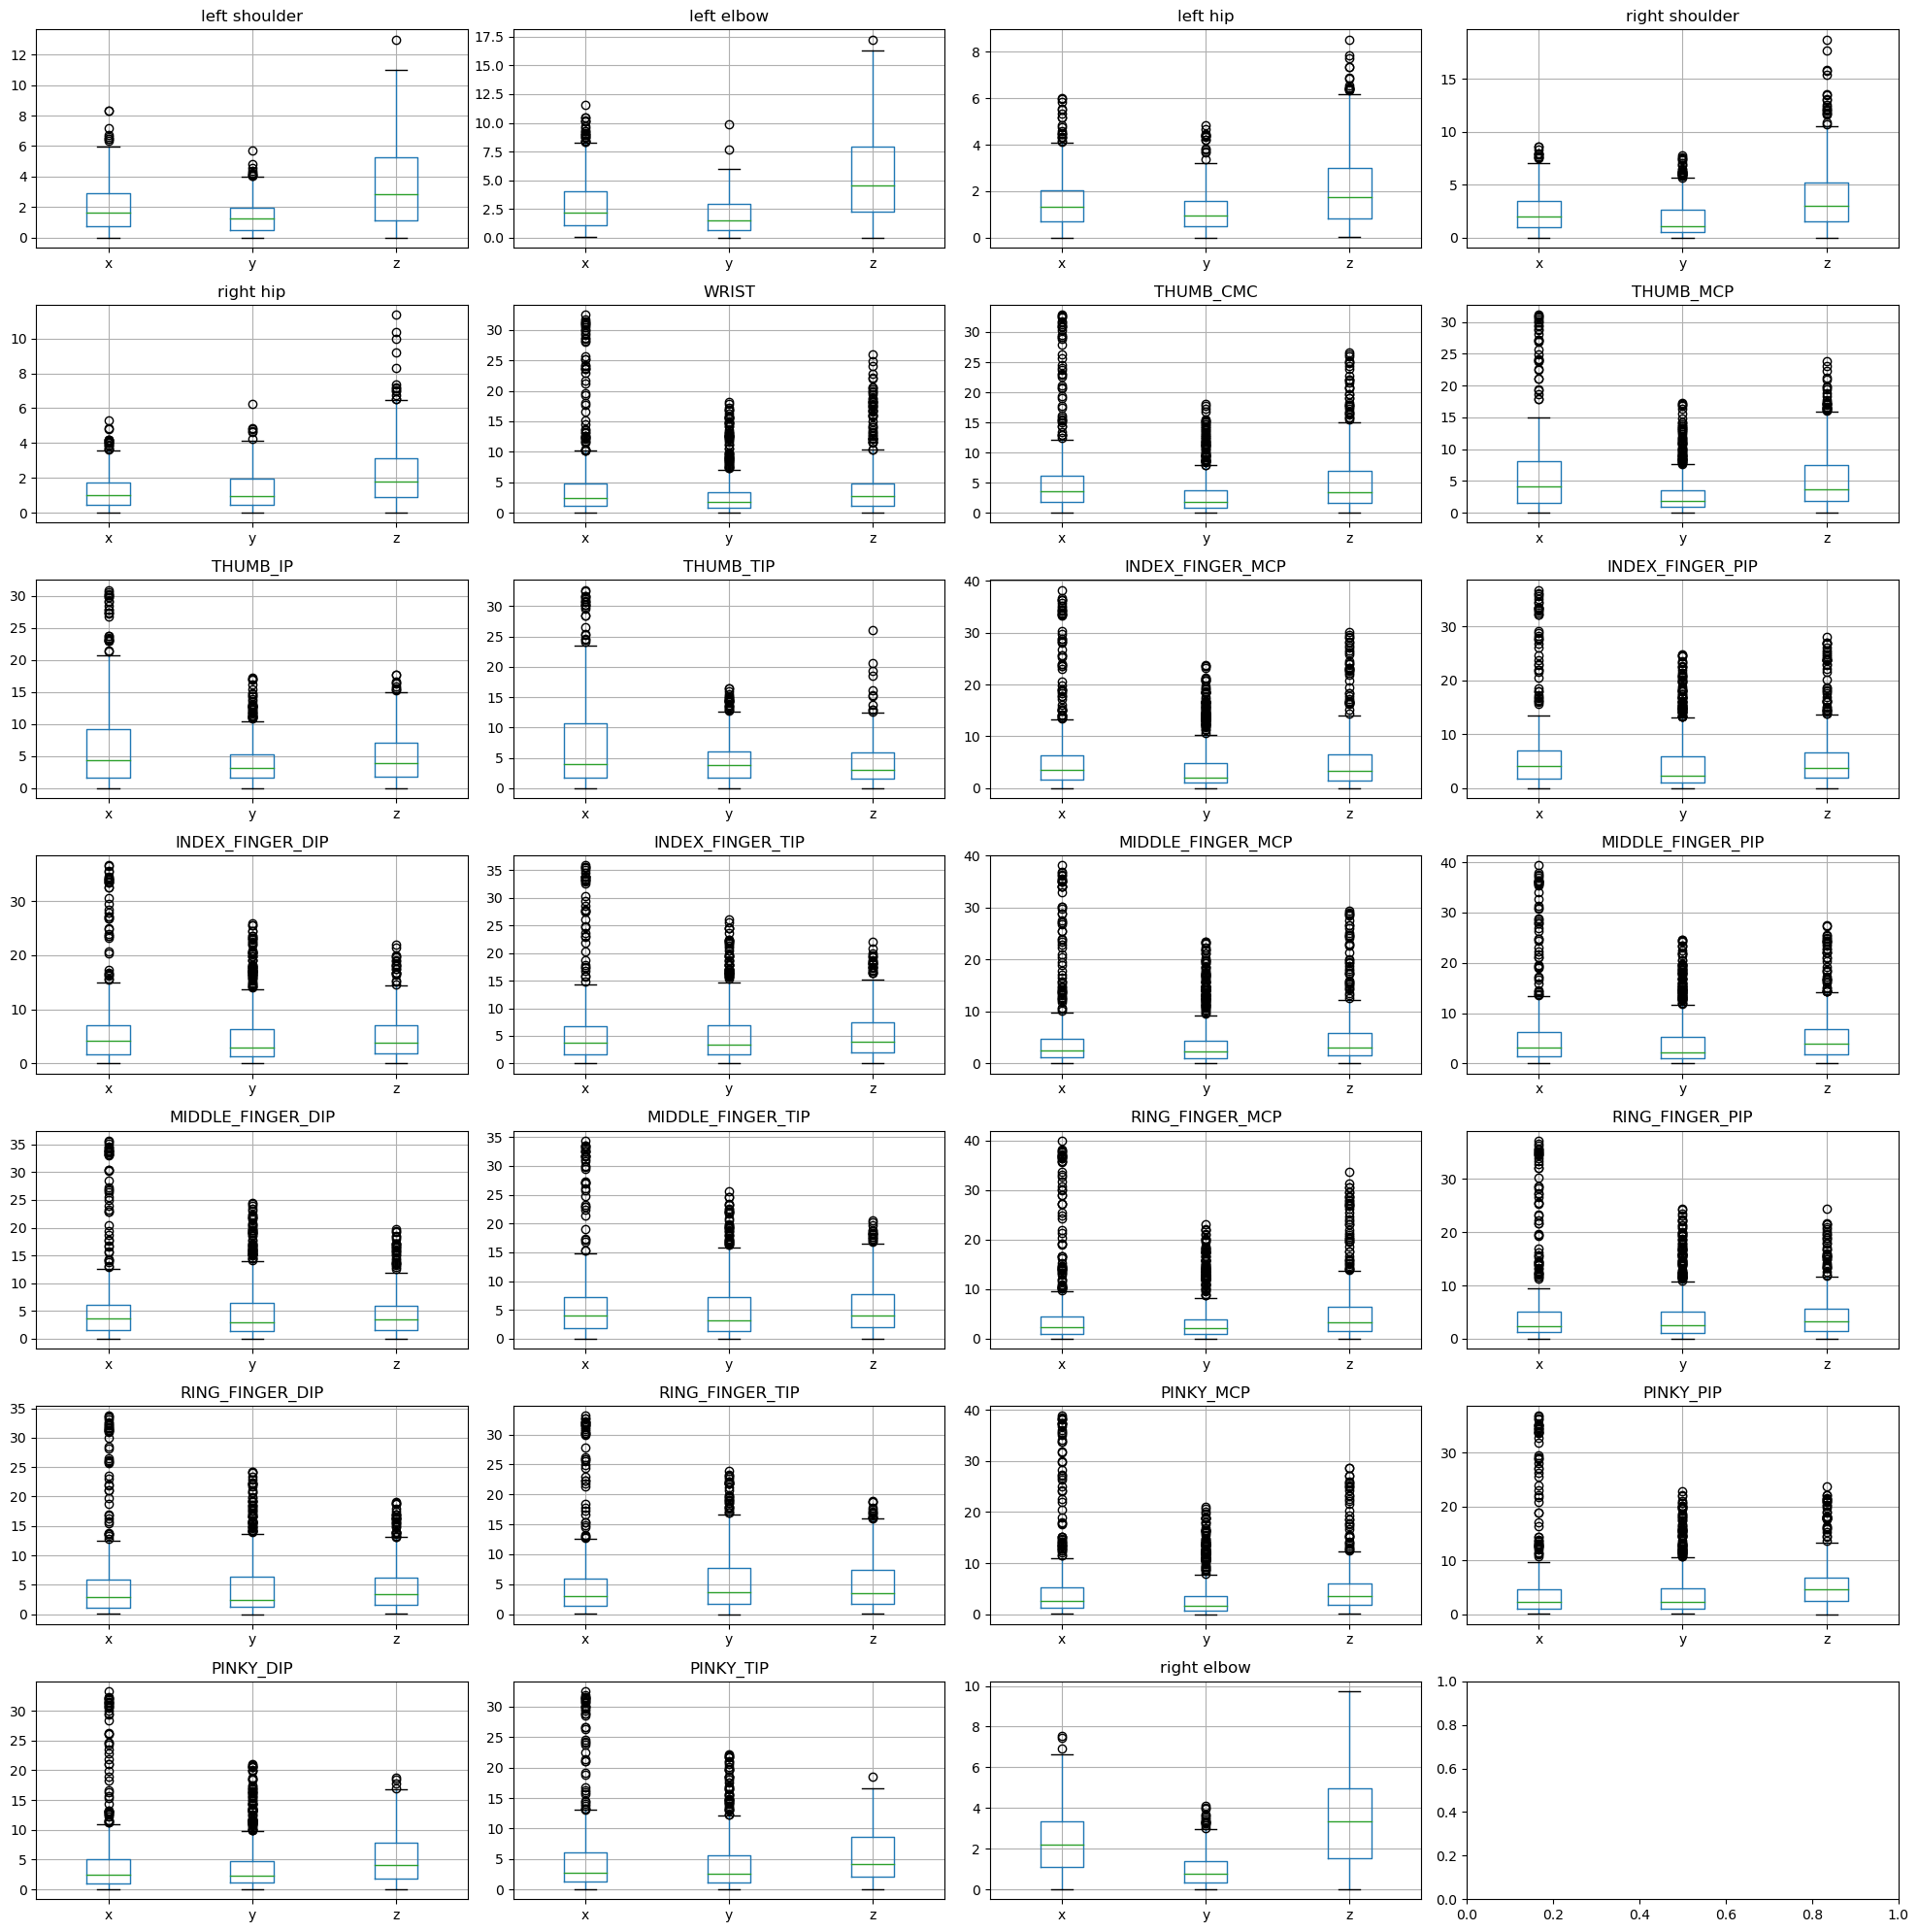

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    lmk_error = lmks_error[:, i, :]

    lmk_error_df = pd.DataFrame(lmk_error, columns=["x", "y", "z"])
    lmk_error_df.boxplot(ax=ax)

    title = arm_hand_fused_names[i]
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [6]:
def get_measure_noise(lmk_error_xyz):
    abs_noise = pd.DataFrame(lmk_error_xyz)
    measure_noise = abs_noise.cov()
    measure_noise = measure_noise.fillna(0)
    return measure_noise

def get_landmark_initial_expectation_and_cov(home_position_file):
    home_position_data = pd.read_csv(home_position_csv_file)
    total_rows = len(home_position_data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = home_position_data.iloc[start_idx:end_idx]
    #gt_data = middle_data.iloc[:, 323:].values
    gt_data = home_position_data.iloc[:, 323:].values

    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    home_init_expectation = []
    home_init_cov = []
    for i, landmark_name in enumerate(arm_hand_fused_names):
        lmk_home_pos = gt_data[:, i, :]
        lmk_home_pos = pd.DataFrame(lmk_home_pos)

        lmk_exp = lmk_home_pos.mean()
        lmk_cov = lmk_home_pos.cov()

        home_init_expectation.append(lmk_exp)
        home_init_cov.append(lmk_cov)

    home_init_expectation = np.array(home_init_expectation)
    home_init_cov = np.array(home_init_cov)

    return home_init_expectation, home_init_cov

Get measure noise (when arm does not move), home position expectation and cov.

In [7]:
landmark_stats_dict = dict()
noise_cov = []

for i, landmark_name in enumerate(arm_hand_fused_names):
    lmk_error_xyz = lmks_error[:, i, :]
    measure_noise = get_measure_noise(lmk_error_xyz)
    noise_cov.append(measure_noise)
    
noise_cov = np.array(noise_cov)
zero_det_mask = np.linalg.det(noise_cov) < 1e-3
avg_noise_cov = np.mean(noise_cov[~zero_det_mask])
noise_cov[zero_det_mask] = avg_noise_cov

In [8]:
# Set all measure noise in hand with the same value
SELECTED_LANDMARK = "MIDDLE_FINGER_MCP"
HAND_LANDMARKS = ["THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP"]

for hand_landmark in HAND_LANDMARKS:
    selected_landmark = arm_hand_fused_names.index(SELECTED_LANDMARK)
    current_hand_landmark = arm_hand_fused_names.index(hand_landmark)
    noise_cov[current_hand_landmark] = noise_cov[selected_landmark]

In [9]:
noise_cov.shape

(27, 3, 3)

In [10]:
home_position_csv_file = "data/2024-09-26/2024-09-26-17:36/landmarks_all_2024-09-26-17:36.csv"
home_init_expectation, home_init_cov = get_landmark_initial_expectation_and_cov(home_position_csv_file)

Plot the initial_expectation to ensure that they form a sticky man

In [11]:
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
lines = body_lines.copy()
lines.extend(lefthand_lines)

In [12]:
colors = [[0, 0, 0] for i in range(len(lines))]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(home_init_expectation)

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(home_init_expectation),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd, line_set], 
    window_name='Open3D Point Cloud Visualization', width=800, height=600)

Save to json file

In [13]:
landmarks_stats_dict = dict()

for i, landmark_name in enumerate(arm_hand_fused_names):
    stats = dict()

    lmk_measure_noise = noise_cov[i]
    lmk_init_expectation = home_init_expectation[i]
    lmk_init_cov = home_init_cov[i]

    stats["measure_noise"] = lmk_measure_noise.flatten().tolist()
    stats["filter_state_estimate"] = lmk_init_expectation.tolist()
    stats["cov"] = lmk_init_cov.flatten().tolist()

    landmarks_stats_dict[landmark_name] = stats

In [14]:
des_json_file = "Hand_pose_estimation_3D/arm_and_hand/landmarks_stats.json"
with open(des_json_file, 'w') as file:
    json.dump(landmarks_stats_dict, file)